# Econ 281: Computational Tools in Macroeconomics

### Homework 2: Policy Iteration and Solvers

##### Youngdoo Choi (yoc005@ucsd.edu), April 2024

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar
from scipy.optimize import root_scalar
import time

---

### Problem 1: Policy Function Iteration and Value Function Iteration

Compare the speed and accuracy of:

- VFI

- VFI with Howard's improvement

- PFI

- EGM

In [2]:
# Set parameters for the consumption-savings problem
beta = 0.99
r = (1/beta) - 1
y = 1.0

# Construct a grids
amin = -1.0; amax = 1.0; agridsize = 200
curv = 1.0
agrid = np.array([amin + (amax-amin) * (a/(agridsize-1))**curv for a in range(agridsize)])

# Etc
max_iter = 10000
tol = 1e-8
prog_freq = 200
updating_factor = 0.2

In [3]:
# Define utility functions
def utility(c):
    return np.log(c)

def marginal_utility(c):
    return 1/c

##### 1. Solve VFI

In [4]:
# Define Bellman operator
def Bellman_Operator(V_old, beta, r, y, agrid, agridsize, utility=utility):

    # Allocate empty outcome vectors
    V_new = np.empty(agridsize)
    saving = np.empty(agridsize)

    # Interpolate the value function
    V_interp = interp1d(agrid, V_old, kind='linear', bounds_error=False, fill_value='extrapolate')

    # Solve the problem
    for (aidx, a) in enumerate(agrid):
        Obj = lambda a_prime: -(utility((1+r)*a+y-a_prime) + beta*V_interp(a_prime)) # objective function
        res = minimize_scalar(Obj, bounds=(agrid[0], agrid[-1]), method='bounded')
        V_new[aidx] = -res.fun
        saving[aidx] = res.x
    consumption = (1+r)*agrid + y - saving

    return V_new, saving, consumption

In [5]:
# Define VFI function
def VFI(V_0, beta=beta, r=r, y=y, agrid=agrid, agridsize=agridsize, max_iter=max_iter, tol=tol, progress=True, prog_freq=prog_freq, utility=utility, Bellman_Operator=Bellman_Operator, howard=1):

    start_time = time.time()
    V_old = V_0

    # Iterate the Bellman operator until convergence
    for iter in range(max_iter):
        if iter % howard == 0:
            V_new, saving, consumption = Bellman_Operator(V_old, beta, r, y, agrid, agridsize)
        else:
            V_interp = interp1d(agrid, V_old, kind='linear', bounds_error=False, fill_value='extrapolate')
            V_new = utility(consumption) + beta*V_interp(saving)

        # Check convergence & update
        error = np.max(np.abs(V_new - V_old))
        if error < tol:
            V_star, saving, consumption = Bellman_Operator(V_new, beta, r, y, agrid, agridsize)
            elapsed_time = "{:.2f}".format(time.time() - start_time)
            print(f"VFI done: {iter} iter, {elapsed_time} seconds")
            return V_star, saving, consumption, elapsed_time
        else:
            V_old = V_new

        # Show progress
        if progress == True and iter % prog_freq == 0:
            print(f"VFI in progress: iter {iter}, error {error}")
    
    if iter == max_iter - 1:
        print("VFI Error: No convergence")

/var/folders/jx/cvyfhs3900vf4n0lf1sp1lz80000gn/T/ipykernel_10920/3743456588.py:3: RuntimeWarning: invalid value encountered in log
  return np.log(c)


VFI in progress: iter 0, error 1.1019723009118272
VFI in progress: iter 200, error 0.0013602054235005712
VFI in progress: iter 400, error 0.00018223981469578376
VFI in progress: iter 600, error 2.441642335493377e-05
VFI in progress: iter 800, error 3.271303288698846e-06
VFI in progress: iter 1000, error 4.3828795481815064e-07
VFI in progress: iter 1200, error 5.87216466563234e-08
VFI done: 1377 iter, 77.82 seconds


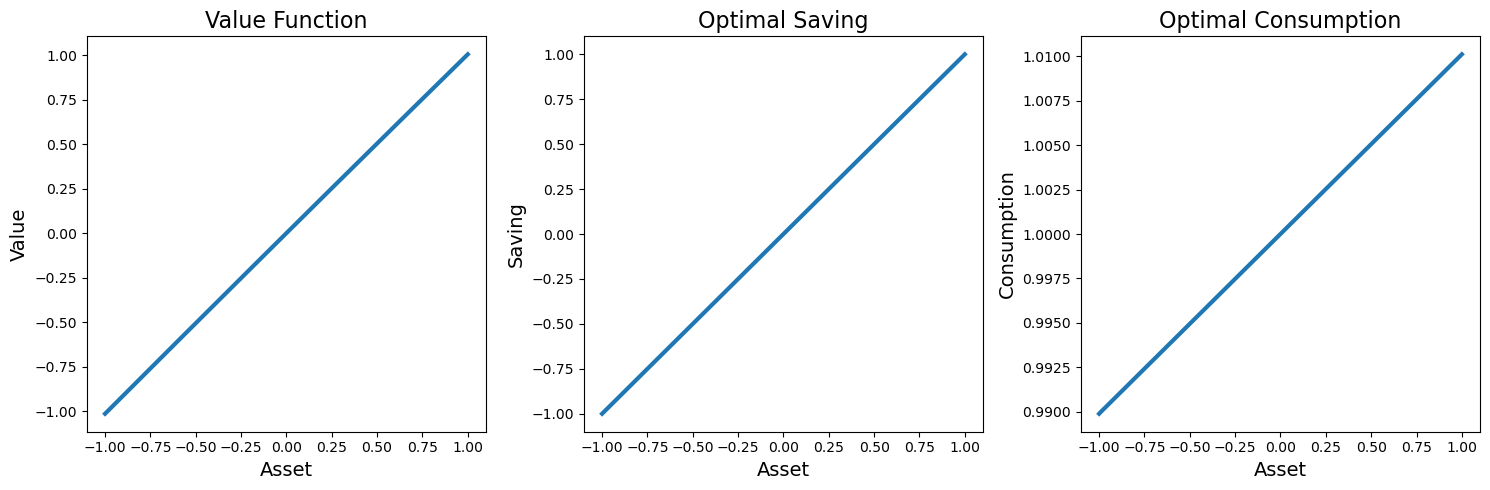

In [6]:
# Solve VFI without Howard's improvement
V_0 = np.zeros(agridsize)
V_VFI, saving_VFI, consumption_VFI, time_VFI = VFI(V_0)

# Plot the graph
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(agrid, V_VFI, linewidth=3)
axs[0].set_xlabel('Asset', fontsize=14)
axs[0].set_ylabel('Value', fontsize=14)
axs[0].set_title('Value Function', fontsize=16)

axs[1].plot(agrid, saving_VFI, linewidth=3)
axs[1].set_xlabel('Asset', fontsize=14)
axs[1].set_ylabel('Saving', fontsize=14)
axs[1].set_title('Optimal Saving', fontsize=16)

axs[2].plot(agrid, consumption_VFI, linewidth=3)
axs[2].set_xlabel('Asset', fontsize=14)
axs[2].set_ylabel('Consumption', fontsize=14)
axs[2].set_title('Optimal Consumption', fontsize=16)

plt.tight_layout()
plt.show()

/var/folders/jx/cvyfhs3900vf4n0lf1sp1lz80000gn/T/ipykernel_10920/3743456588.py:3: RuntimeWarning: invalid value encountered in log
  return np.log(c)


VFI in progress: iter 0, error 1.1019723009118272
VFI in progress: iter 200, error 0.00136020406946058
VFI in progress: iter 400, error 0.0001822395800191723
VFI in progress: iter 600, error 2.4416384730496787e-05
VFI in progress: iter 800, error 3.271297329909828e-06
VFI in progress: iter 1000, error 4.382870062435984e-07
VFI in progress: iter 1200, error 5.87214932235014e-08
VFI done: 1377 iter, 4.39 seconds


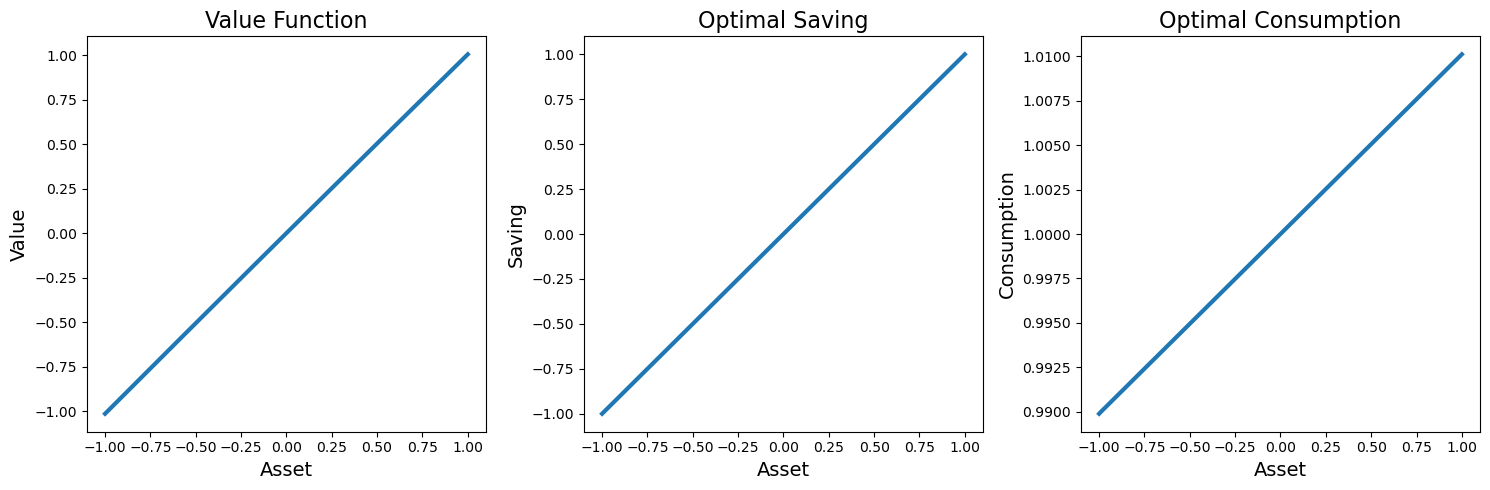

In [7]:
# Solve VFI with Howard's improvement
V_0 = np.zeros(agridsize)
V_Howard, saving_Howard, consumption_Howard, time_Howard = VFI(V_0, howard=20)

# Plot the graph
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(agrid, V_Howard, linewidth=3)
axs[0].set_xlabel('Asset', fontsize=14)
axs[0].set_ylabel('Value', fontsize=14)
axs[0].set_title('Value Function', fontsize=16)

axs[1].plot(agrid, saving_Howard, linewidth=3)
axs[1].set_xlabel('Asset', fontsize=14)
axs[1].set_ylabel('Saving', fontsize=14)
axs[1].set_title('Optimal Saving', fontsize=16)

axs[2].plot(agrid, consumption_Howard, linewidth=3)
axs[2].set_xlabel('Asset', fontsize=14)
axs[2].set_ylabel('Consumption', fontsize=14)
axs[2].set_title('Optimal Consumption', fontsize=16)

plt.tight_layout()
plt.show()

##### 2. Solve PFI

In [8]:
# Define policy function operator
def PF_Operator(a_old, beta, r, y, agrid, agridsize, marginal_utility=marginal_utility):

    # Allocate empty outcome vectors
    a_new = np.empty(agridsize)

    # Interpolate the value function
    a_interp = interp1d(agrid, a_old, kind='linear', bounds_error=False, fill_value='extrapolate')

    # Solve the problem
    for (aidx, a) in enumerate(agrid):
        Obj = lambda a_prime: marginal_utility((1+r)*a+y-a_prime) - beta*(1+r)*marginal_utility((1+r)*a_prime+y-a_interp(a_prime)) # objective function
        res = root_scalar(Obj, bracket=[agrid[0], agrid[-1]], method='brenth')
        a_new[aidx] = res.root
    consumption = (1+r)*agrid + y - a_new

    return a_new, consumption

In [9]:
# Define PFI function
def PFI(a_0, beta=beta, r=r, y=y, agrid=agrid, agridsize=agridsize, max_iter=max_iter, tol=tol, progress=True, prog_freq=prog_freq, updating_factor=updating_factor, PF_Operator=PF_Operator):

    start_time = time.time()
    a_old = a_0

    # Iterate the operator until convergence
    for iter in range(max_iter):
        a_new, consumption = PF_Operator(a_old, beta, r, y, agrid, agridsize)

        # Check convergence & update
        error = np.max(np.abs(a_new - a_old))
        if error < tol:
            elapsed_time = "{:.2f}".format(time.time() - start_time)
            print(f"PFI done: {iter} iter, {elapsed_time} seconds")
            return a_new, consumption, elapsed_time
        else:
            a_old = (1-updating_factor)*a_old + updating_factor*a_new

        # Show progress
        if progress == True and iter % prog_freq == 0:
            print(f"PFI in progress: iter {iter}, error {error}")
    
    if iter == max_iter - 1:
        print("PFI Error: No convergence")

In [10]:
# Solve PFI
a_0 = np.zeros(agridsize)
saving_PFI, consumption_PFI, time_PFI = PFI(a_0, prog_freq=500)

# Plot the graph
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(agrid, saving_PFI, linewidth=3)
axs[0].set_xlabel('Asset', fontsize=14)
axs[0].set_ylabel('Saving', fontsize=14)
axs[0].set_title('Optimal Saving', fontsize=16)

axs[1].plot(agrid, consumption_PFI, linewidth=3)
axs[1].set_xlabel('Asset', fontsize=14)
axs[1].set_ylabel('Consumption', fontsize=14)
axs[1].set_title('Optimal Consumption', fontsize=16)

plt.tight_layout()
plt.show()

ValueError: f(a) and f(b) must have different signs

##### 3. Solve EGM

In [11]:
# Define EGM operator
def EGM_Operator(c_old, beta, r, y, agrid, agridsize):

    c_tilde = np.empty(agridsize)
    a_tilde = np.empty(agridsize)

    # Compute the Euler Eq.
    for (aidx, ap) in enumerate(agrid):
        c_tilde[aidx] = (beta * (1+r) * c_old[aidx]**(-1))**(-1)
        a_tilde[aidx] = (c_tilde[aidx] + ap - y) / (1+r)

    # Compute today's optimal choices
    c_interp = interp1d(a_tilde, c_tilde, kind='linear', bounds_error=False, fill_value='extrapolate')
    c_new = c_interp(agrid)
    saving = (1+r)*agrid + y - c_new

    return c_new, saving

In [12]:
# Define EGM iteration function
def EGM_Iteration(c_0, beta=beta, r=r, y=y, agrid=agrid, agridsize=agridsize, max_iter=max_iter, tol=tol, progress=True, prog_freq=prog_freq, EGM_Operator=EGM_Operator):

    start_time = time.time()
    c_old = c_0

    # Iterate the EGM operator until convergence
    for iter in range(max_iter):
        c_new, saving = EGM_Operator(c_old, beta, r, y, agrid, agridsize)

        # Check convergence & update
        error = np.max(np.abs(c_new - c_old))
        if error < tol:
            c_star = c_new
            elapsed_time = "{:.2f}".format(time.time() - start_time)
            print(f"EGM done: {iter} iter, {elapsed_time} seconds")
            return c_star, saving, elapsed_time
        else:
            c_old = c_new

        # Show progress
        if progress == True and iter % prog_freq == 0:
            print(f"EGM in progress: iter {iter}, error {error}")
    
    if iter == max_iter - 1:
        print("EGM Error: No convergence")

EGM in progress: iter 0, error 0.00817263544536273
EGM in progress: iter 200, error 1.5705059030590718e-05
EGM in progress: iter 400, error 1.6836712477541482e-06
EGM in progress: iter 600, error 2.1933450422562117e-07
EGM in progress: iter 800, error 2.9276939983446937e-08
EGM done: 907 iter, 0.15 seconds


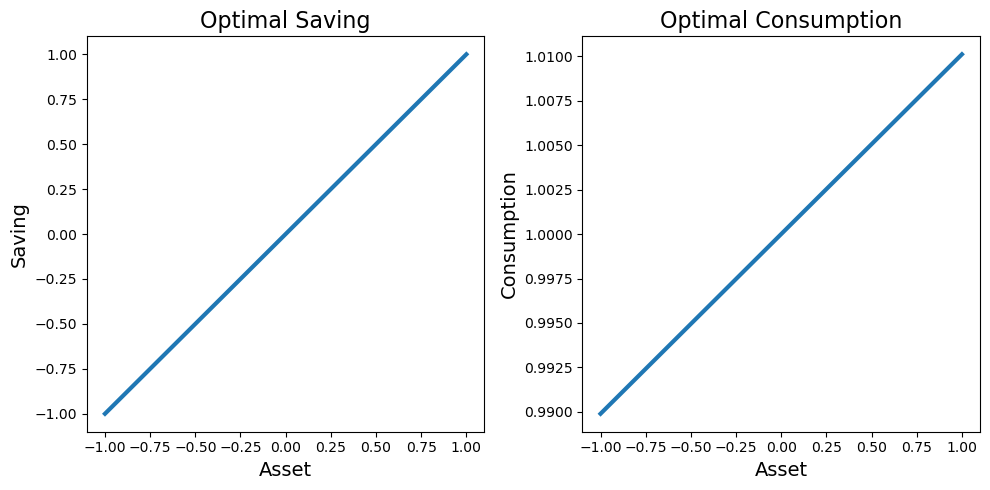

In [13]:
# Solve EGM
c_0 = np.linspace(0.9, 1.1, agridsize)
consumption_EGM, saving_EGM, time_EGM = EGM_Iteration(c_0)

# Plot the graph
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(agrid, saving_EGM, linewidth=3)
axs[0].set_xlabel('Asset', fontsize=14)
axs[0].set_ylabel('Saving', fontsize=14)
axs[0].set_title('Optimal Saving', fontsize=16)

axs[1].plot(agrid, consumption_EGM, linewidth=3)
axs[1].set_xlabel('Asset', fontsize=14)
axs[1].set_ylabel('Consumption', fontsize=14)
axs[1].set_title('Optimal Consumption', fontsize=16)

plt.tight_layout()
plt.show()

##### 4. Compare the speed and accuracy

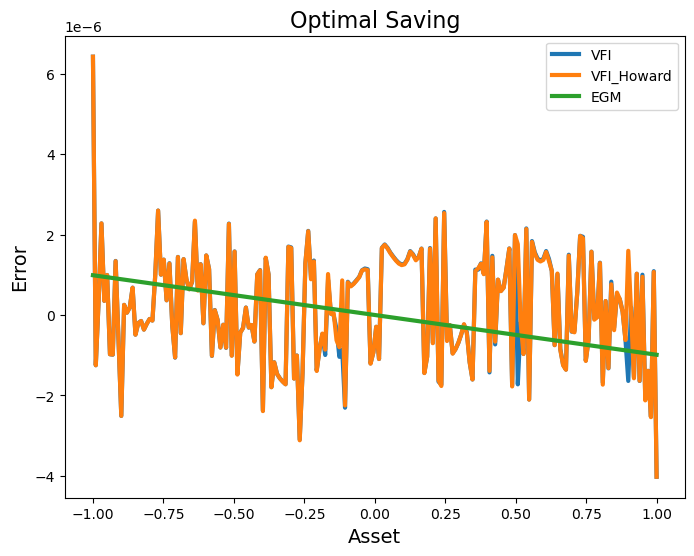

In [14]:
# Compare accuracy
plt.figure(figsize=(8, 6))
plt.plot(agrid, saving_VFI-agrid, linewidth=3, label='VFI')
plt.plot(agrid, saving_Howard-agrid, linewidth=3, label='VFI_Howard')
plt.plot(agrid, saving_EGM-agrid, linewidth=3, label='EGM')
plt.xlabel('Asset', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Optimal Saving', fontsize=16)
plt.legend()
plt.show()

In [15]:
# Compare speed
elapsed_times = [float(time_VFI), float(time_Howard), float(time_EGM)]
labels = ['VFI', 'VFI_Howard', 'EGM']
pd.DataFrame({'Elapsed Time (sec)': elapsed_times}, index=labels)

,Elapsed Time (sec)
VFI,77.82
VFI_Howard,4.39
EGM,0.15


**Takeaways**:

1] For VFIs, using the Howard's algorithm doesn't affect the accuracy much.

2] Using Euler equation directly (EGM) is more accurate.

3] EGM is the fastest since it uses the analytic solution, while VFIs are slow since they are using non-linear solvers.

4] Here PFI doesn't work, due to unstable solutions for the Euler Equation.

---

### Problem 2: Newton-Raphson Method

##### 1. Write a function for the Newton-Rapshon method

In [16]:
# Define a function for the Newton-Rapshon
def Newton_Raphson(Obj, initial_guess, max_iter=100, tol=1e-6, eps=1e-10):

    # Check initial guess
    if np.abs(Obj(initial_guess)) < tol:
        return initial_guess

    x_old = initial_guess
    for iter in range(max_iter):
        slope = (Obj(x_old+eps) - Obj(x_old)) / eps
        x_new = x_old - Obj(x_old) / slope

        # Check convergence & update
        if np.abs(x_new - x_old) < tol:
            return x_new
        else:
            x_old = x_new
    
    if iter == max_iter - 1:
        print("Newton_Raphson Error: No convergence")

##### 2. Find the equilibrium interest rate

In [17]:
# Define a funtion to compute excess saving
def excess_saving(r, agrid=agrid, EGM_Iteration=EGM_Iteration):

    # Compute beta
    beta = 1/(1+r)

    # Compute the saving function
    c_0 = np.linspace(0.9, 1.1, agridsize)
    _, saving, _ = EGM_Iteration(c_0, r=r, beta=beta, progress=False)

    # Compute the excess saving
    #saving_interp = interp1d(agrid, saving, kind='linear', bounds_error=False, fill_value='extrapolate')
    #excess_saving = saving_interp(0)
    excess_saving = saving[100] - agrid[100]
    return excess_saving

EGM done: 138 iter, 0.03 seconds
EGM done: 179 iter, 0.03 seconds
EGM done: 256 iter, 0.05 seconds
EGM done: 455 iter, 0.08 seconds
EGM done: 4586 iter, 0.84 seconds
EGM done: 499 iter, 0.09 seconds
EGM done: 272 iter, 0.05 seconds
EGM done: 187 iter, 0.03 seconds
EGM done: 135 iter, 0.03 seconds
EGM done: 112 iter, 0.02 seconds


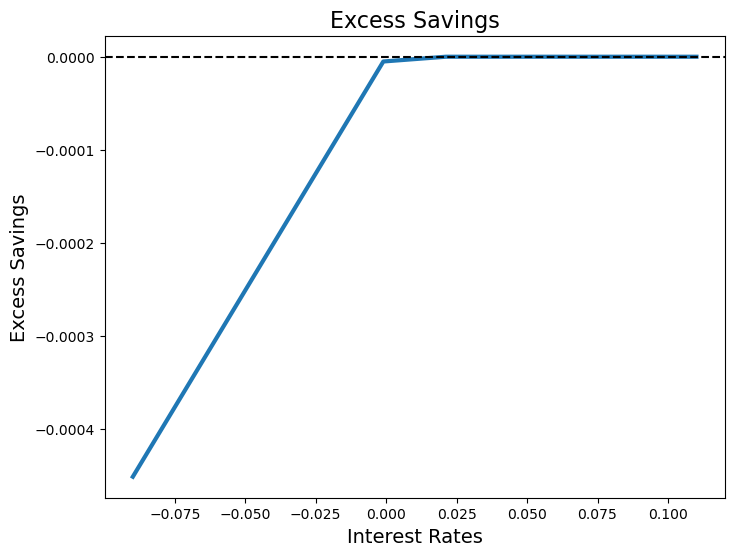

In [18]:
# Compute a few points
rs = (1/beta) - 1 + np.linspace(-0.1, 0.1, 10)
excess_savings = []
for r in rs:
    excess_savings.append(excess_saving(r))

# Plot the points
plt.figure(figsize=(8, 6))
plt.plot(rs, excess_savings, linewidth=3)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Interest Rates', fontsize=14)
plt.ylabel('Excess Savings', fontsize=14)
plt.title('Excess Savings', fontsize=16)
plt.show()

In [19]:
# Solve for the market clearing interest rate
r_star = Newton_Raphson(excess_saving, rs[8])
r_star

EGM done: 135 iter, 0.03 seconds


0.08787878787878795

**Takeaways**:

1] In this case, there's no point to use the root finding functions (solutions are given by plotting several points).

2] In general, Newton_Raphson method is supposed to be much faster since it uses the shape of function (it requires the function to be well-behaving).

---

### Problem 3: Envelope condition method (Arellano et al. 2016)

##### 1. Iterate until the convergence of derivatives

In [20]:
# Define a function to update the derivative
def Vp_Operator(Vp_old, beta, r, y, agrid):
    
    # Compute consumption from the envelope condition
    c = (1+r)/Vp_old

    # Compute saving from the budget constraint
    a_prime = (1+r)*agrid + y - c

    # Update the derivative
    Vp_interp = interp1d(agrid, Vp_old, kind='linear', bounds_error=False, fill_value='extrapolate')
    Vp_new = beta*(1+r)*Vp_interp(a_prime)

    return Vp_new, a_prime, c

In [21]:
# Define the iterator function
def Vp_Iterator(Vp_0, beta=beta, r=r, y=y, agrid=agrid, max_iter=max_iter, tol=tol, progress=True, prog_freq=prog_freq, Vp_Operator=Vp_Operator):

    start_time = time.time()
    Vp_old = Vp_0

    # Iterate the EGM operator until convergence
    for iter in range(max_iter):
        Vp_new, a_prime, c = Vp_Operator(Vp_old, beta, r, y, agrid)

        # Check convergence & update
        error = np.max(np.abs(Vp_new - Vp_old))
        if error < tol:
            elapsed_time = "{:.2f}".format(time.time() - start_time)
            print(f"Vp_Iteration done: {iter} iter, {elapsed_time} seconds")
            return Vp_new, a_prime, c
        else:
            Vp_old = Vp_new

        # Show progress
        if progress == True and iter % prog_freq == 0:
            print(f"Vp_Iteration in progress: iter {iter}, error {error}")
    
    if iter == max_iter - 1:
        print("Vp_Iteration Error: No convergence")

Vp_Iteration in progress: iter 0, error 0.0990000000000002
Vp_Iteration in progress: iter 50, error 8.998806401017134e-05
Vp_Iteration in progress: iter 100, error 3.3831293766439785e-08
Vp_Iteration done: 105 iter, 0.02 seconds


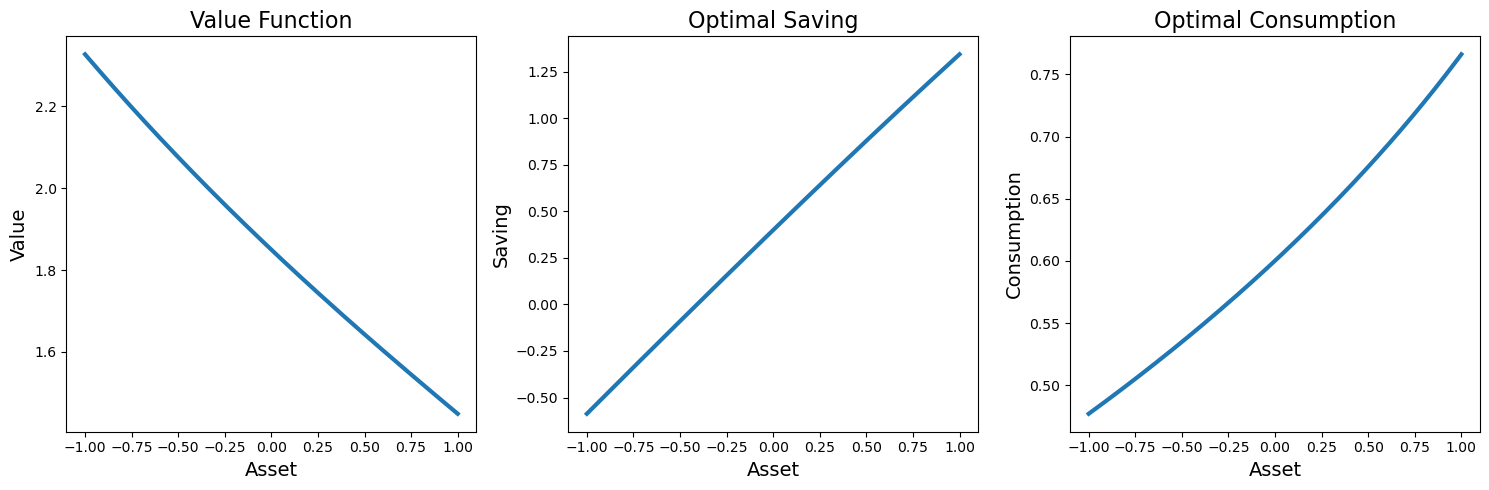

In [22]:
# Solve
Vp_0 = np.linspace(2, 1, agridsize)
Vp_star, saving, consumption = Vp_Iterator(Vp_0, prog_freq=50)

# Plot the graph
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(agrid, Vp_star, linewidth=3)
axs[0].set_xlabel('Asset', fontsize=14)
axs[0].set_ylabel('Value', fontsize=14)
axs[0].set_title('Value Function', fontsize=16)

axs[1].plot(agrid, saving, linewidth=3)
axs[1].set_xlabel('Asset', fontsize=14)
axs[1].set_ylabel('Saving', fontsize=14)
axs[1].set_title('Optimal Saving', fontsize=16)

axs[2].plot(agrid, consumption, linewidth=3)
axs[2].set_xlabel('Asset', fontsize=14)
axs[2].set_ylabel('Consumption', fontsize=14)
axs[2].set_title('Optimal Consumption', fontsize=16)

plt.tight_layout()
plt.show()

**Takeaways**:

1] As we calculate things directly like EGM, this is not computationally heavy.

2] However, due to some issues, this doesn't converge to the true solution